# BE - Benign Equivalized

In [5]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle 

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'oboa\\'
saveModel = 'RF_Models\\'
filename = 'oboa-e02.pkl'

X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=7, max_features='log2', max_depth=20, verbose=2, n_jobs=1)

In [4]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 400


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s


building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 142.9min finished


NameError: name 'pickle' is not defined

In [6]:
pickle.dump(clf, open(saveModel+filename, 'wb'))

# Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.0min finished


Best Threshold=0.407638
Logistic: ROC AUC=0.998
Logistic: ROC AUC=0.500


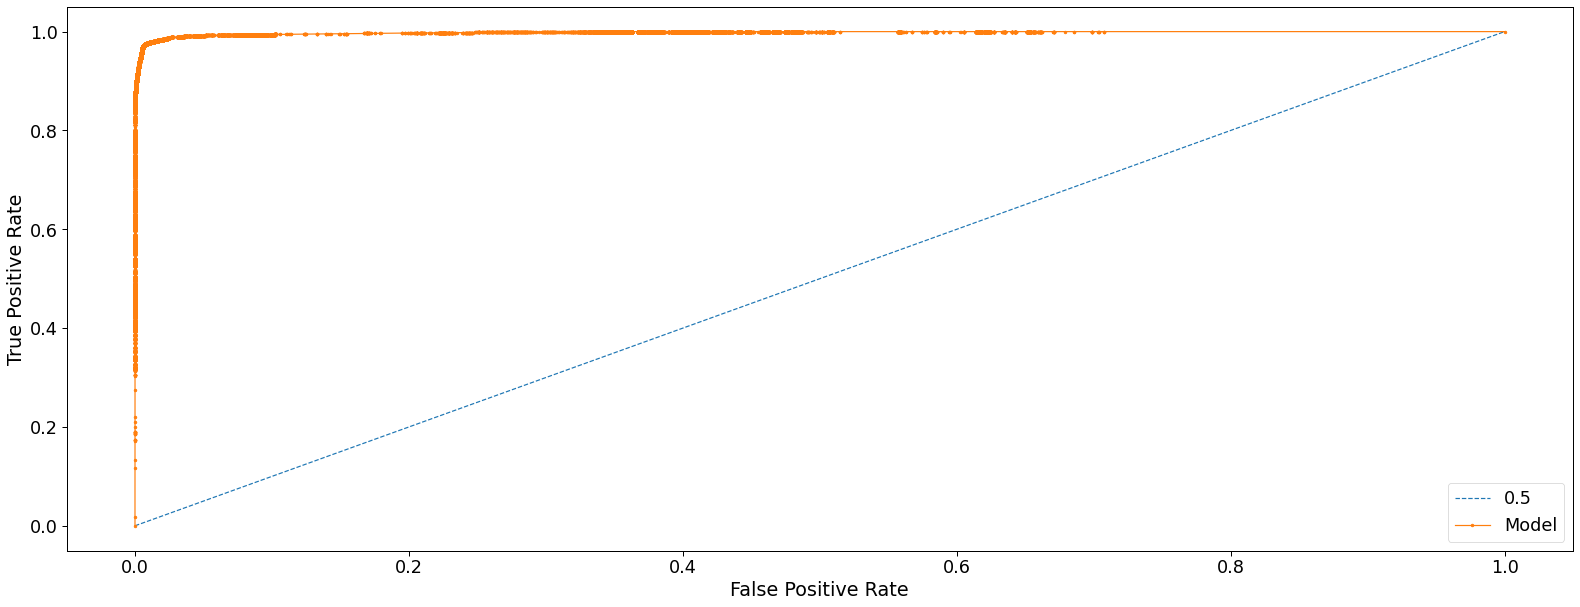

[[1267681   10574]
 [  31718 1246537]]


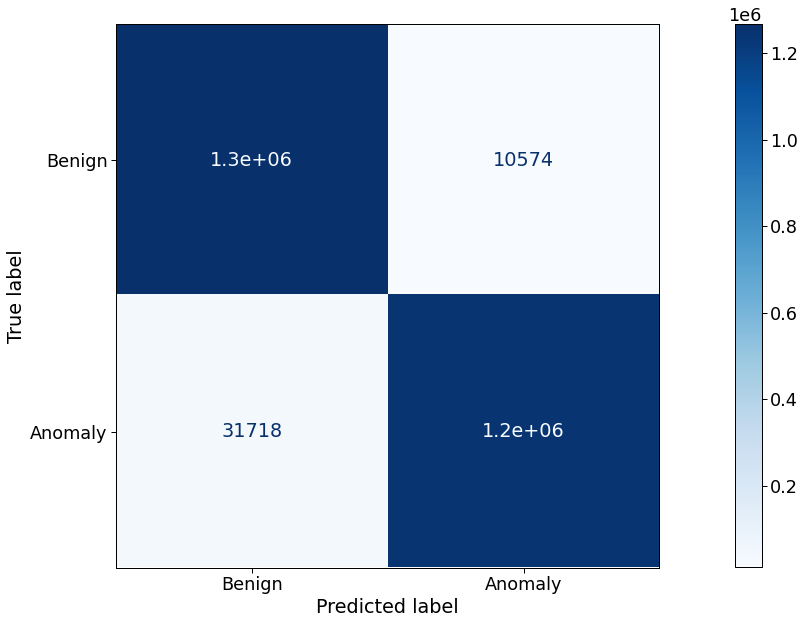

accuracy:  0.9834571349222182
f1:  0.983319173641991
precision:  0.9915886504851202
recall:  0.9751864846998447
mcc:  0.9670465779365798


In [8]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 10.4min finished


Best Threshold=0.159509
Logistic: ROC AUC=0.635
Logistic: ROC AUC=0.500


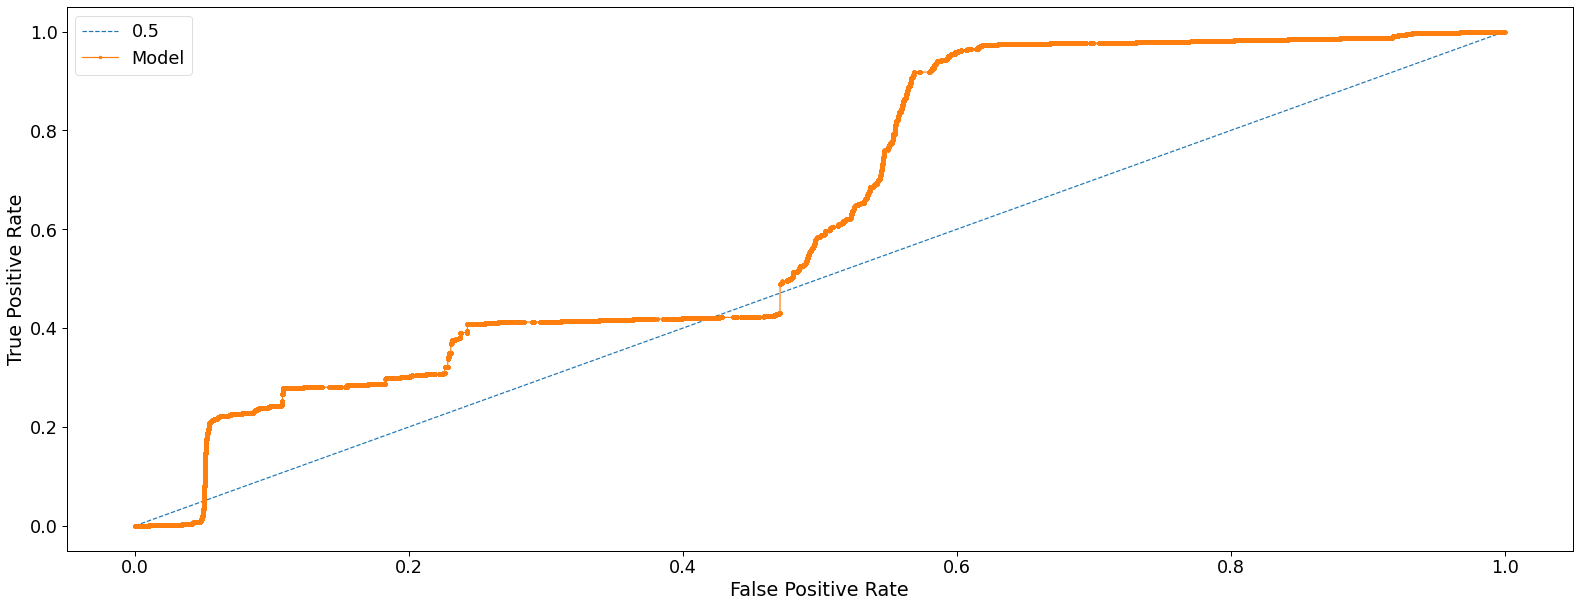

[[9665250  705496]
 [1728089  496415]]


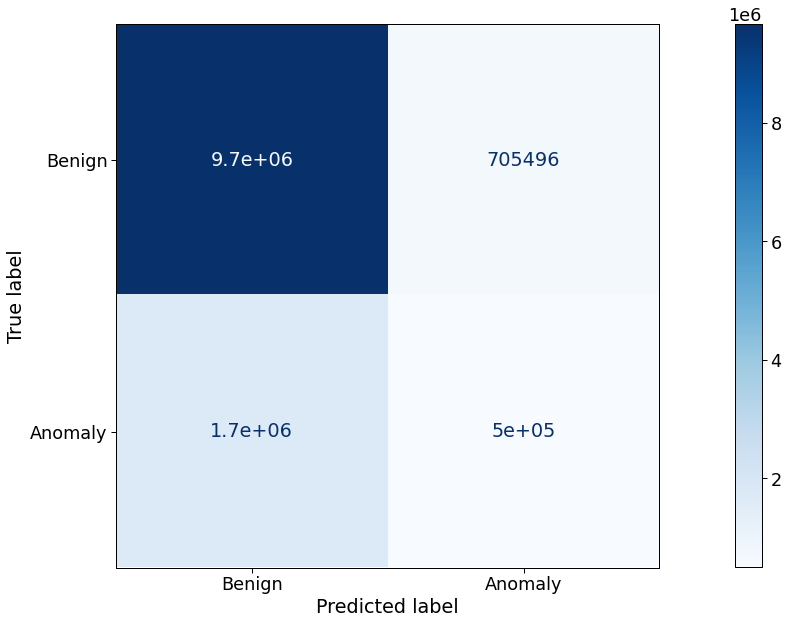

accuracy:  0.8067854945316687
f1:  0.28975766216293125
precision:  0.41302143003932906
recall:  0.22315761176424048
mcc:  0.20135203085106304
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          1                       2094
Brute Force -XSS          1                        895
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    0                          5
                          1                     280332
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432424
                          1                         63
DoS attacks-SlowHTTPTest  1                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      18024
                          1                       7909
Infilteration             0                      10982
                          1                 

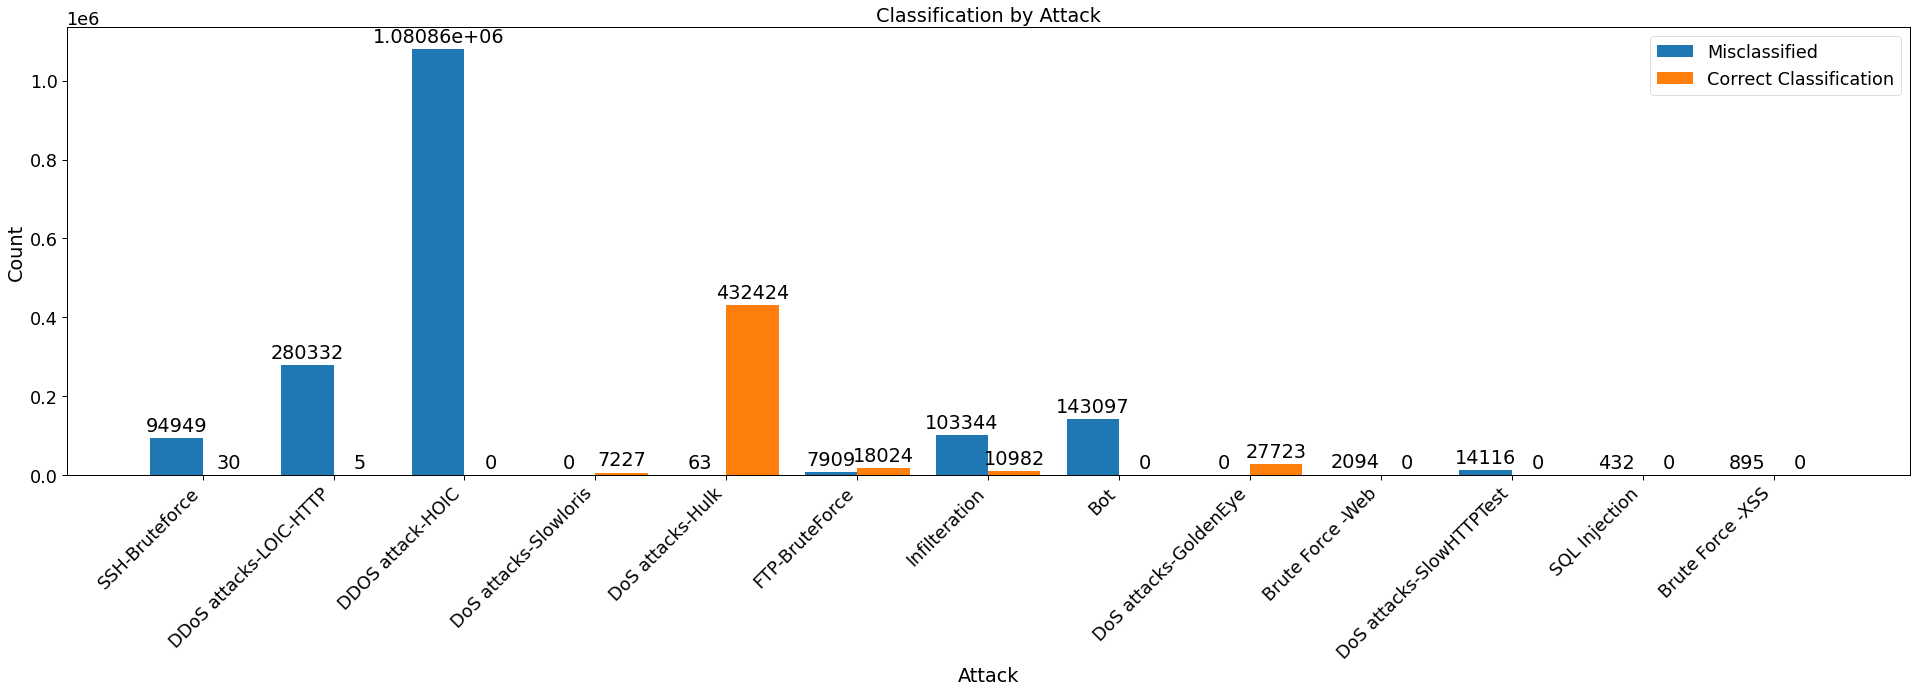

In [9]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.159509
[[4115684 6255062]
 [  85044 2139460]]


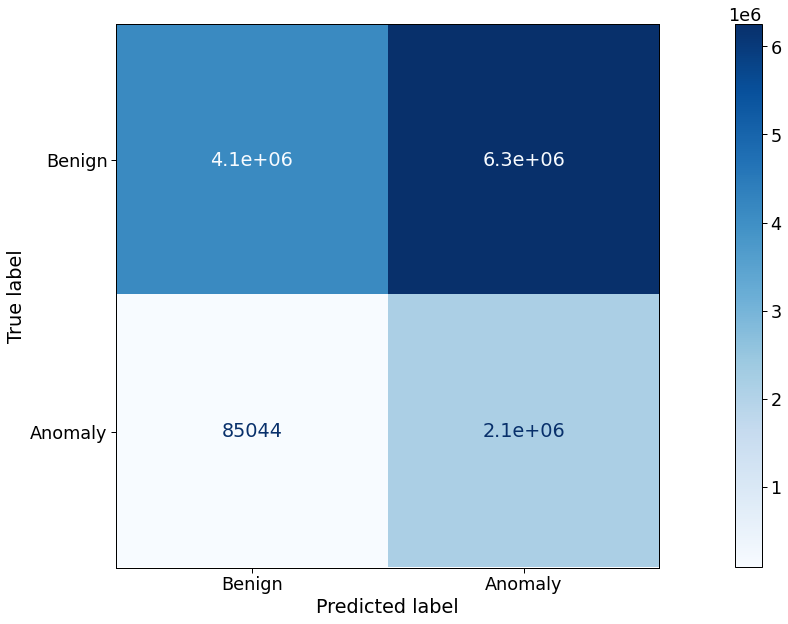

accuracy:  0.4966272205791866
f1:  0.40294844367082255
precision:  0.25486382667172713
recall:  0.9617694551234792
mcc:  0.29006906531117715
attack                    misclassification
Bot                       0                     139840
                          1                       3257
Brute Force -Web          0                       2055
                          1                         39
Brute Force -XSS          0                        877
                          1                         18
DDOS attack-HOIC          0                    1058250
                          1                      22608
DDoS attacks-LOIC-HTTP    0                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                  

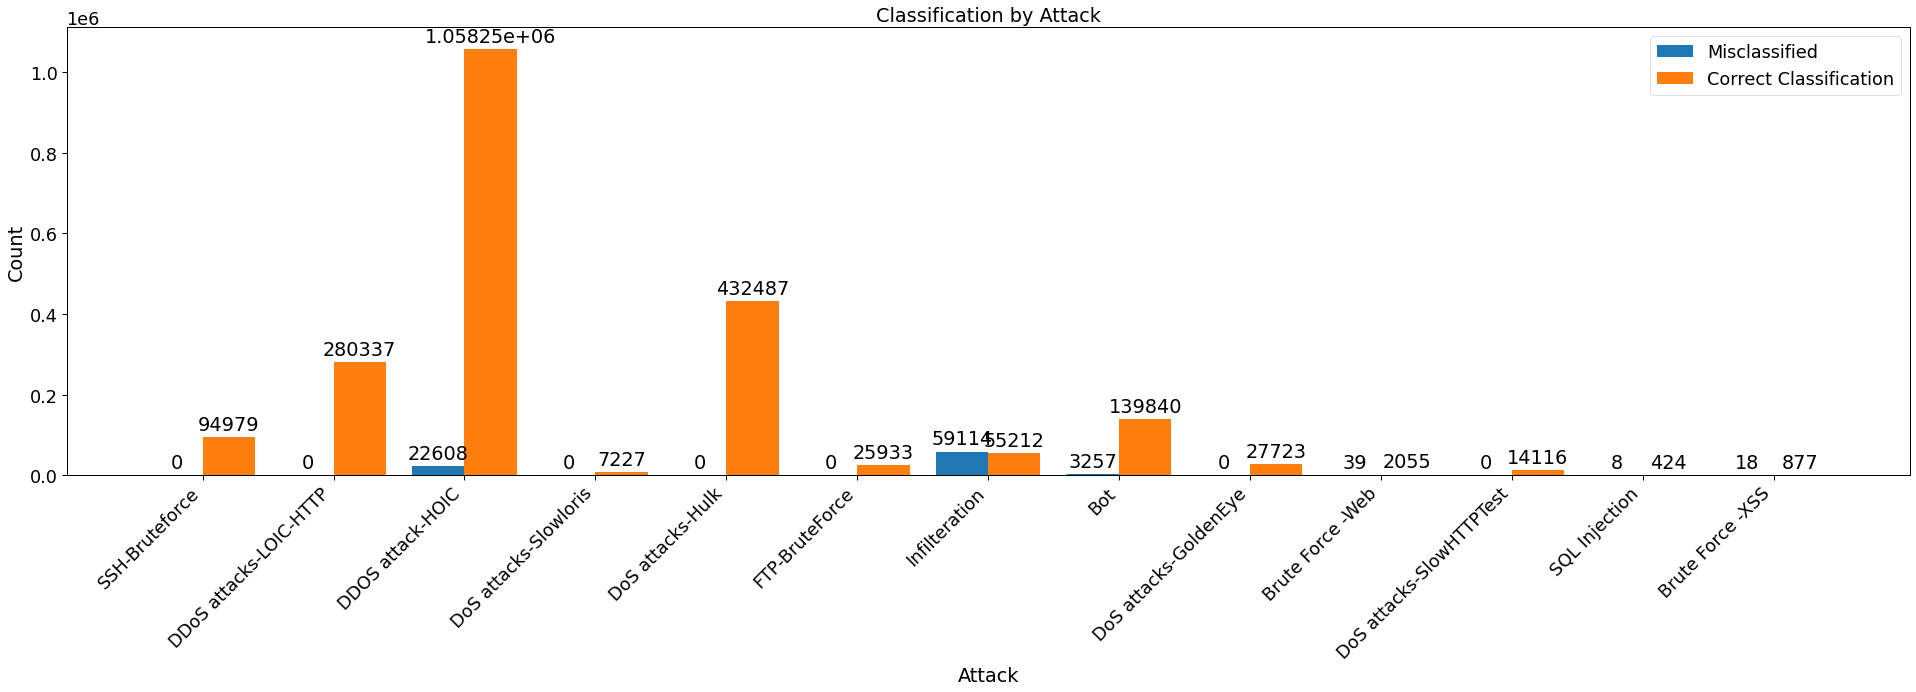

In [10]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.1min finished


Best Threshold=0.363217
Logistic: ROC AUC=0.859
Logistic: ROC AUC=0.500


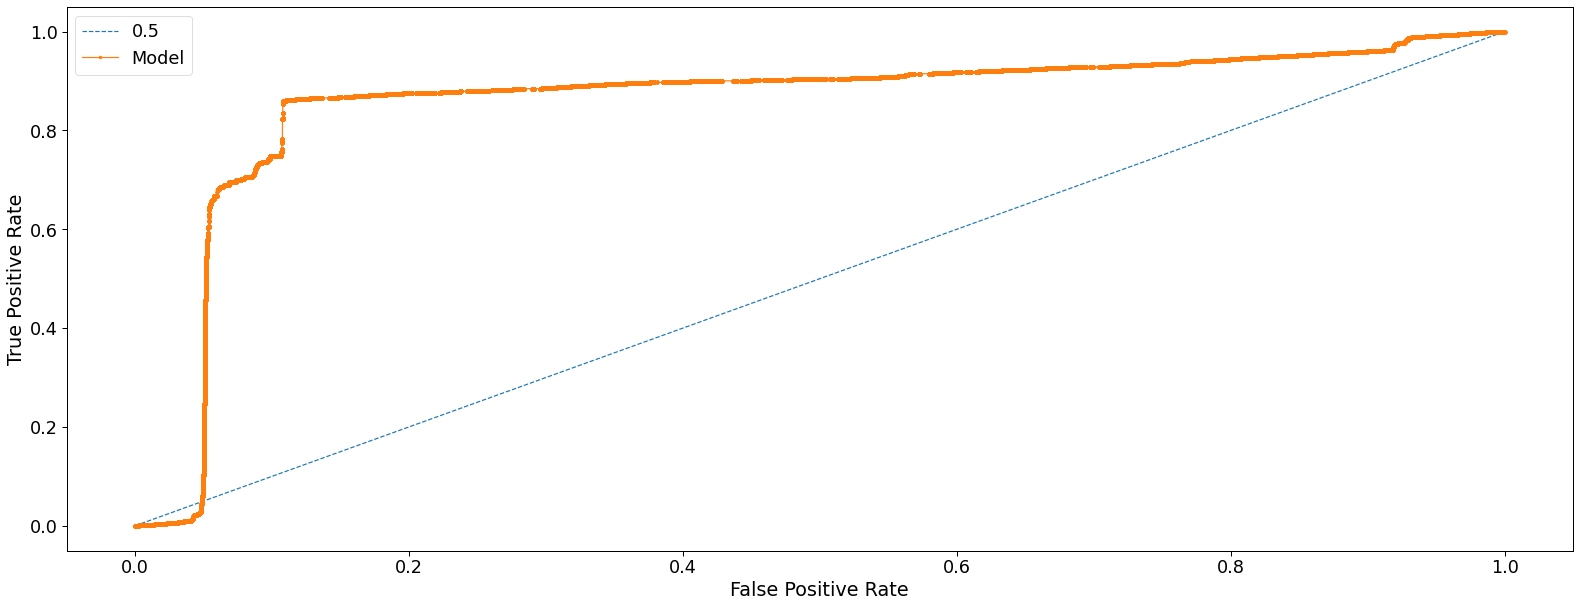

[[9665250  705496]
 [ 223802  496410]]


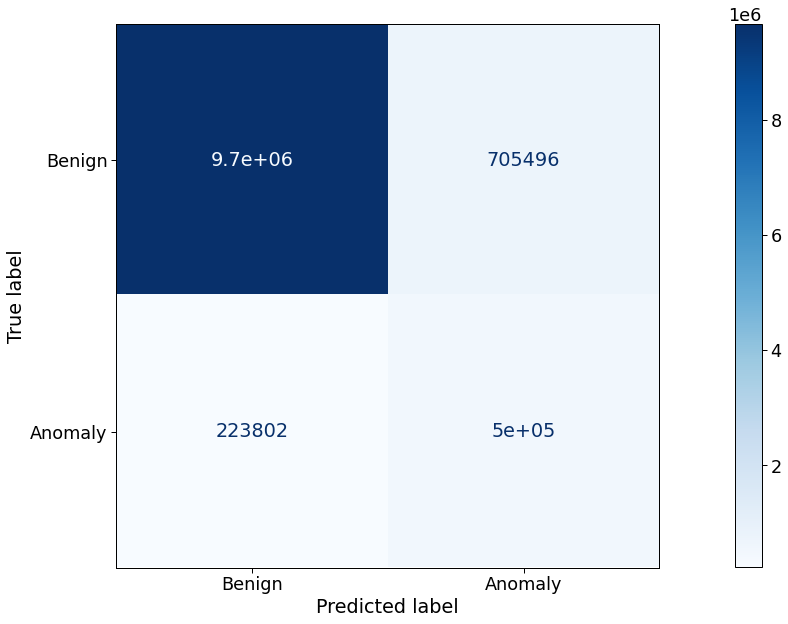

accuracy:  0.9162112055604213
f1:  0.5165239595071687
precision:  0.41301898817378396
recall:  0.6892553859141475
mcc:  0.49246291410900495
attack                    misclassification
Brute Force -Web          1                      2094
Brute Force -XSS          1                       895
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432424
                          1                        63
DoS attacks-SlowHTTPTest  1                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     18024
                          1                      7909
Infilteration             0                     10982
                          1                    103344
SQL Injection             1                       432
SSH-Bruteforce            0                        30
                          1                     94949
dtype: int64
[30, 94949]
[7227]
[432424, 63]
[18024, 7909]
[

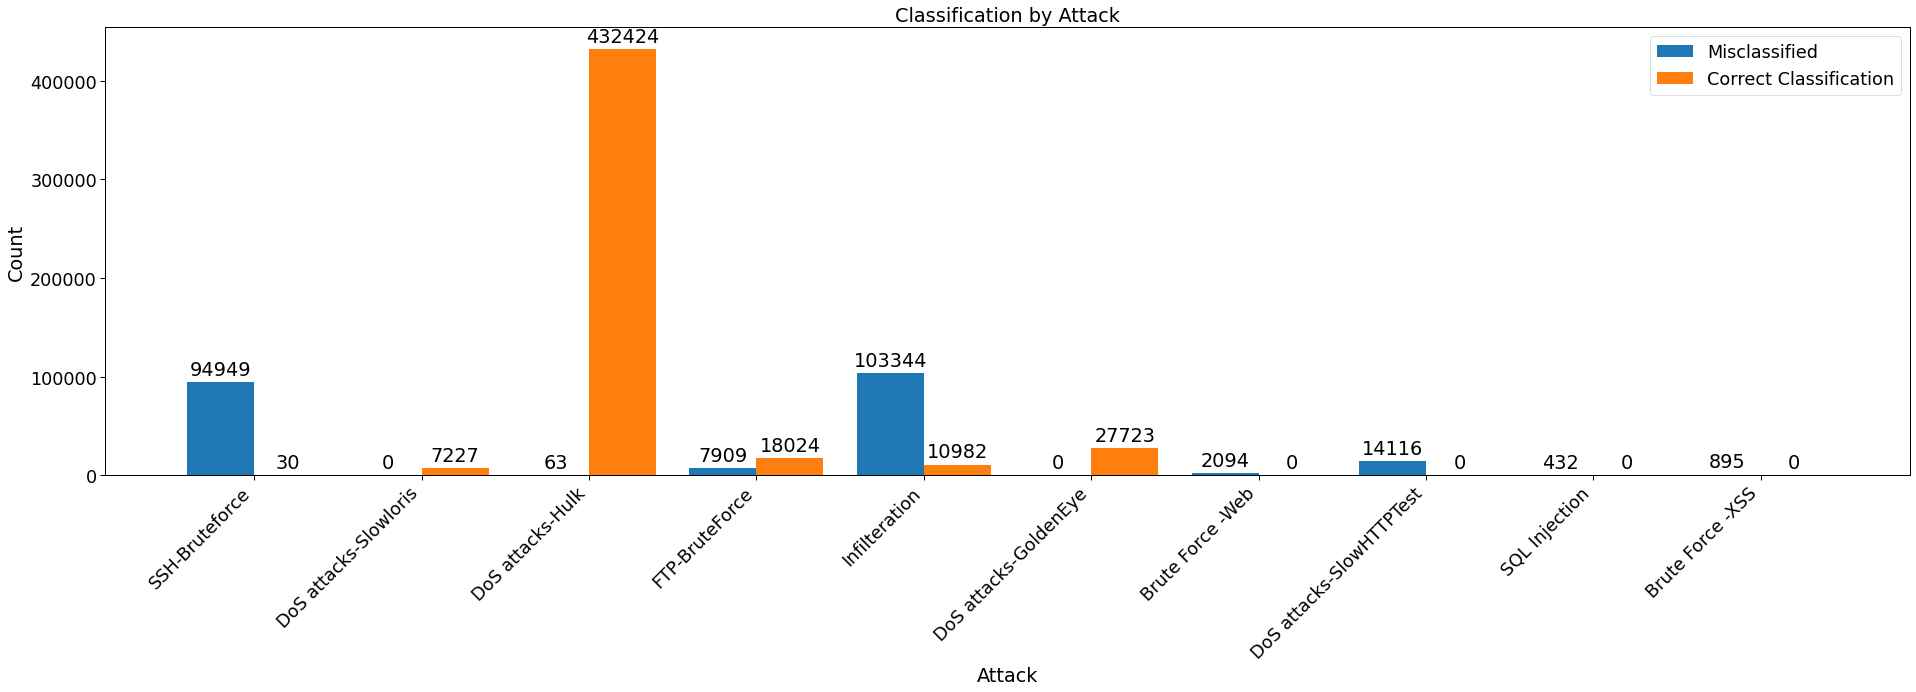

In [11]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)